In [1]:
import numpy as np
import cv2
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim
import torchvision
import torchvision.transforms.functional as tf
import torchvision.transforms as tfs
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.models as models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
import random
import time
import copy
import warnings
warnings.filterwarnings("ignore") # 忽略警告
try: # for torchvision<0.4
    from torchvision.models.utils import load_state_dict_from_url
except: # for torchvision>=0.4
    from torch.hub import load_state_dict_from_url
from collections import OrderedDict
import math
import torch.utils.checkpoint as cp
from torchvision.models._utils import IntermediateLayerGetter
import tensorboardX
from tensorboardX import SummaryWriter
import json
import pandas as pd
import xlsxwriter

## 预处理

In [2]:
############ GID数据集 ###############
COLORCLASS_16c = ('Background','Industrial land','Urban residential','Rural residential','Traffic land',
          'Garden land','Arbor forest','Shrub land',
          'Paddy field','Irrigated land','Dry cropland',
          'Natural meadow','Artificial meadow',
          'River','Lake','Pond')

COLORMAP_16c = [[0, 0, 0],[200,0,0],[250,0,150],[200,150,150],[250,150,150],
            [200,0,200],[150,0,250],[150,150,250],
            [0,200,0],[150,250,0],[150,200,150],
            [250,200,0],[200,200,0],
            [0,0,200],[0,150,200],[0,200,250]]

COLORCLASS_6c = ['Background','Building','Forest','Farmland','Meadow','Water']

COLORMAP_6c = [[0, 0, 0],[255, 0, 0],[0, 255, 255],[0, 255, 0], [255, 255, 0],[0, 0, 255]]

COLORCLASS_c = ('B_B','Building_Industrial','Building_Urban','Building_Rural','Building_Traffic',
          'Forest_Garden','Forest_Arbor','Forest_Shrub',
          'Farmland_Paddy','Farmland_Irrigated','Farmland_Dry',
          'Meadow_Natural','Meadow_Artificial',
          'Water_River','Water_Lake','Water_Pond')
COLORMAP_c = [[0,0,0],[200,0,0],[250,0,150],[200,150,150],[250,150,150],
            [200,0,200],[150,0,250],[150,150,250],
            [0,200,0],[150,250,0],[150,200,150],
            [250,200,0],[200,200,0],
            [0,0,200],[0,150,200],[0,200,250]]

cm2lbl_16 = np.zeros(256**3)
cm2lbl_6 = np.zeros(256**3)
cm2lbl = np.zeros(256**3)

# 枚举的时候i是下标，cm是一个三元组，分别标记了RGB值
for i, cm in enumerate(COLORMAP_16c):
    cm2lbl_16[(cm[0]*256 + cm[1])*256 + cm[2]] = i
for i, cm in enumerate(COLORMAP_6c):
    cm2lbl_6[(cm[0]*256 + cm[1])*256 + cm[2]] = i
for i, cm in enumerate(COLORMAP_c):
    cm2lbl[(cm[0]*256 + cm[1])*256 + cm[2]] = i
    
# 将标签按照RGB值填入对应类别的下标信息
def image2label_16(im):
    data = np.array(im, dtype="int32")
    idx = (data[:,:,0]*256 + data[:,:,1])*256 + data[:,:,2]
    return np.array(cm2lbl_16[idx], dtype="int64")

def image2label_6(im):
    data = np.array(im, dtype="int32")
    idx = (data[:,:,0]*256 + data[:,:,1])*256 + data[:,:,2]
    return np.array(cm2lbl_6[idx], dtype="int64")

def image2label(im):
    data = np.array(im, dtype="int32")
    idx = (data[:,:,0]*256 + data[:,:,1])*256 + data[:,:,2]
    return np.array(cm2lbl[idx], dtype="int64")

In [3]:
gid_root = r"D:\TSL\data\GID10_clip"
def read_images(root=gid_root, train=True):
    txt_fname = root + '/'+('train.txt' if train else 'val.txt')
    # print(txt_fname)
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root,'images',i+'.tif') for i in images]
    label1 = [os.path.join(root,'gtCoarse',i+'.tif') for i in images]
    label2 = [os.path.join(root,'gtFine',i+'.tif') for i in images]
    return data, label1, label2

In [4]:
def image_transforms(data,label1,label2): 
    # 将数据转换成tensor，并且做标准化处理

    im_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # label_tfs = tfs.ToTensor()

    data = im_tfs(data)
    # print(data)
    label1 = image2label_6(label1)
    label1 = torch.from_numpy(label1)
    label2 = image2label_16(label2)
    label2 = torch.from_numpy(label2)
    # label1 = label_tfs(label1)
    # label2 = label_tfs(label2)
    # label = torch.from_numpy(label)# 将numpy数组转换成tensor
    return data,label1,label2

In [5]:
class GIDSegDataset(torch.utils.data.Dataset):
    
    # 构造函数
    def __init__(self, train, height, width, transforms):

        self.height = height
        self.width = width
        self.fnum = 0    # 用来记录被过滤的图片数
        self.transforms = transforms
        data_list, label1_list, label2_list = read_images(train=train)
        # data_list, label_list= read_images(train=train)
        self.data_list = self._filter(data_list)
        self.label1_list = self._filter(label1_list)
        self.label2_list = self._filter(label2_list)
        # self.label_list = self._filter(label_list)
        if(train==True):
            print("训练集：加载了 " + str(len(self.data_list)) + " 张图片和标签" + ",过滤了" + str(self.fnum) + "张图片")
        else:
            print("测试集：加载了 " + str(len(self.data_list)) + " 张图片和标签" + ",过滤了" + str(self.fnum) + "张图片")
        
    
    # 过滤掉长小于height和宽小于width的图片
    def _filter(self, images): 
        img = []
        for im in images:
            if (Image.open(im).size[1] >= self.height and 
               Image.open(im).size[0] >= self.width):
                img.append(im)
            else:
                self.fnum  = self.fnum+1
        return img
    
    # 重载getitem函数，使类可以迭代
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label1 = self.label1_list[idx]
        label2 = self.label2_list[idx]
        # label =self.label_list[idx]
        
        img = Image.open(img)
        # label1 = cv2.imread(label1,cv2.IMREAD_GRAYSCALE)
        # label2 = cv2.imread(label2,cv2.IMREAD_GRAYSCALE)
        label1 = Image.open(label1).convert('RGB')
        label2 = Image.open(label2).convert('RGB')
        img, label1,label2  = self.transforms(img, label1,label2)
        # img, label1, label2 = self.transforms(img, label1, label2)
        return img, label1,label2
    
    def __len__(self):
        return len(self.data_list)

In [6]:
'''
image=(C,H,W)
label=(H,W)
'''
height = 512
width = 512
gid_train = GIDSegDataset(True, height, width, image_transforms)
gid_val = GIDSegDataset(False, height, width, image_transforms)
train_data = DataLoader(gid_train, batch_size=4,shuffle=True)#,num_workers=8
valid_data = DataLoader(gid_val, batch_size=4)#,num_workers=8

训练集：加载了 5760 张图片和标签,过滤了0张图片
测试集：加载了 640 张图片和标签,过滤了0张图片


## 模型

In [5]:
class _SimpleSegmentationModel(nn.Module):#对骨干网络的导入
    def __init__(self, backbone, classifier1,classifier2):
        super(_SimpleSegmentationModel, self).__init__()
        self.backbone = backbone
        self.classifier1 = classifier1 #设定好骨干网和分类器
        self.classifier2 = classifier2
        self.class_nb1 = 6
        self.class_nb2 = 16
        self.logsigma = nn.Parameter(torch.FloatTensor([-0.5, -0.5]))
        self.tasks = ['segmentation1', 'segmentation2']
        self.num_out_channels = {'segmentation1': 6, 'segmentation2': 16}
        # self.decoders = nn.ModuleList([DeepLabHead(2048, self.num_out_channels[t]) for t in self.tasks])
        self.decoders = nn.ModuleList([self.classifier1, self.classifier2])
        
    def forward(self, x):
        input_shape = x.shape[-2:] #输入数据一般为[batch_size,channels,h,w]，取最后2个维度，即长和宽。
        features = self.backbone(x) #获得骨干网输出的feature-map输出
        # print('features[out]',features['out'].shape)
        out = [0 for _ in self.tasks]
        out_middle = [0 for _ in self.tasks]
        for i, t in enumerate(self.tasks):
            if i == 0:
                features = self.backbone(x)
                # print('features',features.shape)
                out_middle[i]=self.decoders[i](features)
                # print('out_middle0',out_middle[i].shape)
                out[i] = F.interpolate(out_middle[i], size=input_shape, mode='bilinear', align_corners=True)
                # print('out0',out[i].shape)
            else:
                features = self.backbone(x)
                feateres_shape= features['out'].shape[-2:]
                out_middle[i] = F.interpolate(out_middle[i-1], size=feateres_shape, mode='bilinear', align_corners=True)
                # print('out_middle1',out_middle[i].shape)
                features['out'] = torch.cat((features['out'],out_middle[i]),dim=1)
                # print('features_out',features['out'].shape)
                out[i] = F.interpolate(self.decoders[i](features), size=input_shape, mode='bilinear', align_corners=True)
                # print('out1',out[i].shape)
        return out,self.logsigma


In [6]:
__all__ = ["DeepLabV3"]

class DeepLabV3(_SimpleSegmentationModel):
    pass

class DeepLabHeadV3Plus(nn.Module):
    def __init__(self, in_channels, low_level_channels, num_classes, aspp_dilate=[12, 24, 36]): #原论文中是[6, 12, 18]，此处有所更改。
        super(DeepLabHeadV3Plus, self).__init__()
        self.project = nn.Sequential( 
            nn.Conv2d(low_level_channels, 48, 1, bias=False), #论文原文中描述输出通道数48比64好，所以用48。从空洞卷积输出的low level feature传入1*1卷积。
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
        )
        self.aspp = ASPP(in_channels, aspp_dilate)
        self.classifier = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, 1)
        )
        self._init_weight()

    def forward(self, feature): #feature就是骨干网输出的特征数据
        low_level_feature = self.project( feature['low_level'] ) #self.project 1*1卷积
        # print("low_level_feature:",low_level_feature.shape)
        output_feature = self.aspp(feature['out'])
        # print("out_feature_未上采样:",output_feature.shape)
        output_feature = F.interpolate(output_feature, size=low_level_feature.shape[2:], mode='bilinear', align_corners=False)
        # print("out_feature:",output_feature.shape)
        return self.classifier(torch.cat([low_level_feature, output_feature], dim=1))
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

class DeepLabHead(nn.Module):
    def __init__(self, in_channels, num_classes, aspp_dilate=[12, 24, 36]):
        super(DeepLabHead, self).__init__()

        self.classifier = nn.Sequential(
            ASPP(in_channels, aspp_dilate),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, 1)
        )
        self._init_weight()

    def forward(self, feature):
        return self.classifier( feature['out'] )

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

class AtrousSeparableConvolution(nn.Module):
    """ Atrous Separable Convolution 空洞可分离卷积，相对与之前的深度可分离卷积（DW+PW）的区别，就是把DW的dilation换成1以外的值，即使用空洞卷积
    """
    def __init__(self, in_channels, out_channels, kernel_size,
                            stride=1, padding=0, dilation=1, bias=True):
        super(AtrousSeparableConvolution, self).__init__()
        self.body = nn.Sequential(
            # Separable Conv
            nn.Conv2d( in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias, groups=in_channels ),
            # PointWise Conv
            nn.Conv2d( in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=bias),
        )
        
        self._init_weight()

    def forward(self, x):
        return self.body(x)

    def _init_weight(self): #初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):  #此处的主要参数为：空洞dilation。
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False), #论文中kernel=3。padding=dilation保证不同卷积核，获得的结果尺寸相同，以便整合。
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        super(ASPPConv, self).__init__(*modules)

class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        size = x.shape[-2:]
        x = super(ASPPPooling, self).forward(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates):
        super(ASPP, self).__init__()
        out_channels = 256
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)))

        rate1, rate2, rate3 = tuple(atrous_rates)
        modules.append(ASPPConv(in_channels, out_channels, rate1))
        modules.append(ASPPConv(in_channels, out_channels, rate2))
        modules.append(ASPPConv(in_channels, out_channels, rate3))
        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(5 * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),)

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)



def convert_to_separable_conv(module):
    new_module = module
    if isinstance(module, nn.Conv2d) and module.kernel_size[0]>1:
        new_module = AtrousSeparableConvolution(module.in_channels,
                                      module.out_channels, 
                                      module.kernel_size,
                                      module.stride,
                                      module.padding,
                                      module.dilation,
                                      module.bias)
    for name, child in module.named_children():
        new_module.add_module(name, convert_to_separable_conv(child))
    return new_module

In [7]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # x = self.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

#pretrained为Ture返回预训练模型，progress为ture显示进度条
def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [8]:
############## resnet骨干网络 ############
def _segm_resnet(name, num_classes1,num_classes2, output_stride, pretrained_backbone):

    if output_stride==8: #如果output_stride==8，则用dilation替代stride设置为[False, True, True]，空洞卷积设置为[12, 24, 36]。
        replace_stride_with_dilation=[False, True, True]
        aspp_dilate = [12, 24, 36]
    else: #如果output_stride！=8，则参数设置为如下值。
        replace_stride_with_dilation=[False, False, True]
        aspp_dilate = [6, 12, 18]
        
    #选择骨干网络
    backbone = resnet50( #从resnet.__dict__选择骨干网的具体名称
        pretrained=pretrained_backbone,
        replace_stride_with_dilation=replace_stride_with_dilation)
    
    inplanes = 2048 #输入和 low_level_planes设定。
    low_level_planes = 256

    if name=='deeplabv3plus':  #下面部分同_segm_hrnet函数的解释。
        return_layers = {'layer4': 'out', 'layer1': 'low_level'}
        classifier1 = DeepLabHeadV3Plus(inplanes, low_level_planes, num_classes1, aspp_dilate)
        classifier2 = DeepLabHeadV3Plus(2054, low_level_planes, num_classes2, aspp_dilate)
    elif name=='deeplabv3':
        return_layers = {'layer4': 'out'}
        classifier1 = DeepLabHead(inplanes , num_classes1, aspp_dilate)
        classifier2 = DeepLabHead(inplanes , num_classes2, aspp_dilate)
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    model = DeepLabV3(backbone, classifier1,classifier2)
    return model

In [9]:
# torch.set_printoptions(precision=4,sci_mode=False) #不显示科学计数法
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model=_segm_resnet('deeplabv3plus',num_classes1=6,num_classes2=16,output_stride=8,pretrained_backbone=True)
num_parameters = count_parameters(model)
print("Number of parameters:", num_parameters)
a=torch.randn(3,3,256,256)
# a=torch.randn(2,3,8,8)
# print(a.shape)
b,c=model(a)
print(b[0].shape)
print(b[1].shape)
print(c)

Number of parameters: 56055064
torch.Size([3, 6, 256, 256])
torch.Size([3, 16, 256, 256])
Parameter containing:
tensor([-0.5000, -0.5000], requires_grad=True)


## loss

In [12]:
#16类精细标注
hiera_map = [0,1,1,1,1,2,2,2,3,3,3,4,4,5,5,5] #upper
#6类
hiera_index = [[0,1],[1,5],[5,8],[8,11],[11,13],[13,16]] ##lower

hiera = {
    "hiera_high":{
        "background":[0,1],
        "Building":[1,5],
        "Forest":[5, 8],
        "Farmland":[8, 11],
        "Meadow":[11, 13],
        "Water":[13, 16],
    }
}

def prepare_targets(targets):
    b, h, w = targets.shape
    targets_high = torch.ones((b, h, w), dtype=targets.dtype, device=targets.device)*255
    indices_high = []
    for index, high in enumerate(hiera["hiera_high"].keys()):
        indices = hiera["hiera_high"][high]
        for ii in range(indices[0], indices[1]):
            targets_high[targets == ii] = index
        indices_high.append(indices)
    
    return targets, targets_high, indices_high


def losses_hiera(predictions6, predictions16, targets, targets_top, num_classes, indices_high, eps=1e-8, gamma=2):
    b, _, h, w = predictions6.shape #预测结果通道数为总类别，GID数据集就是5+15
    predictions6 = torch.sigmoid(predictions6.float())
    # print('predictions6',predictions6)
    predictions16 = torch.sigmoid(predictions16.float())
    # print('predictions16',predictions16)
    # print("predictions:",predictions.shape)
    void_indices = (targets==255)
    # print("void_indices:",void_indices.shape)
    targets[void_indices]=0
    targets = F.one_hot(targets, num_classes=num_classes).permute(0,3,1,2)
    # targets = F.one_hot(targets.to(torch.int64), num_classes=num_classes).permute(0,3,1,2)###修改过
    # print(targets.shape)
    void_indices2 = (targets_top==255)
    targets_top[void_indices2]=0
    targets_top = F.one_hot(targets_top, num_classes = 6).permute(0,3,1,2)
    # targets_top = F.one_hot(targets_top.to(torch.int64), num_classes = 7).permute(0,3,1,2)###修改过
    # print(targets_top.shape)
    
    #####如果子节点属于正确的父节点，选取
    # MCMA = predictions[:,:num_classes,:,:]# 前19个通道
    MCMA = predictions16 
    MCMB = torch.zeros((b,6,h, w), dtype=predictions6.dtype, device=predictions6.device)
    for ii in range(6):
        indices = indices_high[ii]
        MCMB[:,ii:ii+1,:,:] = torch.max(torch.cat([predictions16[:,indices_high[ii][0]:indices_high[ii][1],:,:], predictions6[:,ii:ii+1,:,:]], dim=1), 1, True)[0]
   
    MCLB = predictions6
    MCLA = predictions16.clone()
    for ii in range(6):
        indices = indices_high[ii]
        for jj in range(indices_high[ii][0], indices_high[ii][1]):
            #(B,19,H,W)，父节点
            MCLA[:,jj:jj+1,:,:] = torch.min(torch.cat([predictions16[:,jj:jj+1,:,:],MCLB[:,ii:ii+1,:,:]], dim=1), 1, True)[0]   
            
    valid_indices = (~void_indices).unsqueeze(1) #取反，false变true,(B,1,H,W)
    num_valid = valid_indices.sum() #总的像素个数
    valid_indices2 = (~void_indices2).unsqueeze(1)
    num_valid2 = valid_indices2.sum()
    #channel_num*sum()/one_channel_valid already has a weight
    loss = ((-targets[:,:num_classes,:,:]*torch.log(MCLA+eps)
             -(1.0-targets[:,:num_classes,:,:])*torch.log(1.0-MCMA+eps))
             *valid_indices).sum()/num_valid/num_classes
    loss+= ((-targets_top[:,:,:,:]*torch.log(MCLB+eps)
             -(1.0-targets_top[:,:,:,:])*torch.log(1.0-MCMB+eps))
             *valid_indices2).sum()/num_valid2/6

    return 5*loss

############结合层次化损失和 Focal Loss#########3
def losses_hiera_focal(predictions6, predictions16, targets, targets_top, num_classes, indices_high, eps=1e-8, gamma=2):
    b, _, h, w = predictions6.shape #预测结果通道数为总类别，GID数据集就是5+15
    predictions6 = torch.sigmoid(predictions6.float())
    # print('predictions6',predictions6)
    predictions16 = torch.sigmoid(predictions16.float())
    # print('predictions16',predictions16)
    void_indices = (targets==255)
    targets[void_indices]=0
    targets = F.one_hot(targets, num_classes=num_classes).permute(0,3,1,2)
    void_indices2 = (targets_top==255)
    targets_top[void_indices2]=0
    targets_top = F.one_hot(targets_top, num_classes = 6).permute(0,3,1,2)
    
    MCMA = predictions16 
    MCMB = torch.zeros((b,6,h, w), dtype=predictions6.dtype, device=predictions6.device)
    for ii in range(6):
        indices = indices_high[ii]
        MCMB[:,ii:ii+1,:,:] = torch.max(torch.cat([predictions16[:,indices_high[ii][0]:indices_high[ii][1],:,:], predictions6[:,ii:ii+1,:,:]], dim=1), 1, True)[0]  
        
    MCLB = predictions6
    MCLA = predictions16.clone()
    for ii in range(6):
        indices = indices_high[ii]
        for jj in range(indices_high[ii][0], indices_high[ii][1]):
            #(B,19,H,W)，父节点
            MCLA[:,jj:jj+1,:,:] = torch.min(torch.cat([predictions16[:,jj:jj+1,:,:],MCLB[:,ii:ii+1,:,:]], dim=1), 1, True)[0]   
            
    valid_indices = (~void_indices).unsqueeze(1) #取反，false变true,(B,1,H,W)
    num_valid = valid_indices.sum() #总的像素个数
    valid_indices2 = (~void_indices2).unsqueeze(1)
    num_valid2 = valid_indices2.sum()
    '''
    MCLA:更新后的前16个通道
    MCMA:原始预测的前16个通道
    MCLB：原始预测的后6个通道
    MCMB：更新后的前6个通道
    '''
    #channel_num*sum()/one_channel_valid already has a weight
    loss = ((-targets[:,:num_classes,:,:]*torch.pow((1.0-MCLA),gamma)*torch.log(MCLA+eps)
             -(1.0-targets[:,:num_classes,:,:])*torch.pow(MCMA, gamma)*torch.log(1.0-MCMA+eps))
             *valid_indices).sum()/num_valid/num_classes
    loss+= ((-targets_top[:,:,:,:]*torch.pow((1.0-MCLB), gamma)*torch.log(MCLB+eps)
             -(1.0-targets_top[:,:,:,:])*torch.pow(MCMB, gamma)*torch.log(1.0-MCMB+eps))
             *valid_indices2).sum()/num_valid2/6

    return 5*loss

################层次化三元组损失#############3##
# @LOSSES.register_module()
class HieraTripletLossCityscape(nn.Module):
    def __init__(self,
                 num_classes,
                 use_sigmoid=False,
                 loss_weight=1.0):
        super(HieraTripletLossCityscape, self).__init__()
        self.num_classes = num_classes
        self.loss_weight = loss_weight
        # self.treetripletloss = TreeTripletLoss(16, hiera_map, hiera_index)
        self.ce = nn.CrossEntropyLoss()
    #cls_score为预测结果
    '''
    step
    embedding：是模型backbone提取的图像特征表示,用于计算triplet loss以提升模型区分不同类别的能力。
    cls_score_before
    cls_score为预测结果：[n,26,256,256]
    label为真实标签：[n,256,256]，值为0-19
    weight'''
    def forward(self,
                # step,
                # embedding,
                # cls_score_before,
                cls_score1,
                cls_score2,
                label,
                weight=None,
                **kwargs):
        targets, targets_top, indices_top = prepare_targets(label)
        # print("targets:",targets)
        # print("targets_top:",targets_top)
        # print("indices_top:",indices_top)
        ####分层损失
        loss = losses_hiera_focal(cls_score1,cls_score2, targets, targets_top, self.num_classes, indices_top)  #分层损失
        # # print("loss_hiera:",loss)
        # ce_loss = self.ce(cls_score2,label)  #16类的损失
        # # print("19类的损失:",ce_loss)
        # ce_loss2 = self.ce(cls_score1,targets_top)  #6类的损失
        # # print("7类的损失:",ce_loss2)
        # loss = loss + ce_loss + ce_loss2
        # print("总损失:",loss)
        
        ####三元组损失
        # loss_triplet, class_count = self.treetripletloss(embedding, label)
        # print("loss_triplet:",loss_triplet)
        # print("class_count:",class_count)
        # class_counts = [torch.ones_like(class_count) for _ in range(torch.distributed.get_world_size())]
        # torch.distributed.all_gather(class_counts, class_count, async_op=False)
        # class_counts = torch.cat(class_counts, dim=0)
        # '''
        # 当step<80000时,factor以cos函数形式与step成正比，当step>=80000时,factor固定为0.5
        # step参数控制着triple loss在总loss中的权重,与训练进程的关联。
        # '''
        # if torch.distributed.get_world_size()==torch.nonzero(class_counts, as_tuple=False).size(0):
        #     factor = 1/4*(1+torch.cos(torch.tensor((step.item()-80000)/80000*math.pi))) if step.item()<80000 else 0.5
        # loss+=factor*loss_triplet
            
        return loss*self.loss_weight

## 训练

In [13]:
class ConfMatrix(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, pred, target):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=pred.device)
        with torch.no_grad():
            k = (target >= 0) & (target < n)
            inds = n * target[k].to(torch.int64) + pred[k]
            self.mat += torch.bincount(inds, minlength=n ** 2).reshape(n, n)
    def get_metrics(self):
        h = self.mat.float()
        acc = torch.diag(h).sum() / h.sum()
        iu = torch.diag(h) / (h.sum(1) + h.sum(0) - torch.diag(h))
        return torch.mean(iu).item(), acc.item()

In [14]:
def multi_task_trainer(train_loader, test_loader, multi_task_model, device, optimizer, scheduler, opt, total_epoch=50):
    log_data = {'train': {'epochs': [], 'steps': [], 'loss_6': [],'loss_16': [], 'accuracy_6': [],'accuracy_16': [], 'miou_6': [],'miou_16': []},
            'eval': {'epochs': [], 'steps': [], 'loss_6': [],'loss_16': [], 'accuracy_6': [], 'accuracy_16': [], 'miou_6': [],'miou_16': []}}
    train_batch = len(train_loader)
    test_batch = len(test_loader)
    hieratripletloss=HieraTripletLossCityscape(num_classes=16,use_sigmoid=False,loss_weight=1.0)
    criterion = nn.CrossEntropyLoss()
    T = opt['temp']
    avg_cost = np.zeros([total_epoch, 14], dtype=np.float32) #(200,12)
    #(total_epoch,12:train_loss1、train_miou1、train_acc1、train_loss2、train_miou2、train_acc2、val_loss1、val_miou1、val_acc1、val_loss2、val_miou2、val_acc2)
    lambda_weight = np.ones([2, total_epoch])
    for index in range(total_epoch):
        cost = np.zeros(14, dtype=np.float32) #(12,)

        # apply Dynamic Weight Average
        if opt['weight'] == 'dwa':
            if index == 0 or index == 1:
                lambda_weight[:, index] = 1.0
            else:
                w_1 = avg_cost[index - 1, 0] / avg_cost[index - 2, 0]
                w_2 = avg_cost[index - 1, 3] / avg_cost[index - 2, 3]
                lambda_weight[0, index] = 2 * np.exp(w_1 / T) / (np.exp(w_1 / T) + np.exp(w_2 / T) )
                lambda_weight[1, index] = 2 * np.exp(w_2 / T) / (np.exp(w_1 / T) + np.exp(w_2 / T) )
                
        # iteration for all batches
        multi_task_model.train()
        train_dataset = iter(train_loader)
        conf_mat1 = ConfMatrix(multi_task_model.class_nb1)
        conf_mat2 = ConfMatrix(multi_task_model.class_nb2)                                                    
        for k in range(train_batch):
            train_data, train_label1, train_label2 = next(train_dataset)
            train_data, train_label1,train_label2= train_data.to(device), train_label1.to(device),train_label2.to(device)
            train_pred, logsigma = multi_task_model(train_data)
            optimizer.zero_grad()
            hieraloss = hieratripletloss(train_pred[0],train_pred[1],train_label2,weight=None)
            train_loss = [criterion(train_pred[0], train_label1),
                          criterion(train_pred[1], train_label2)]
            
            if opt['weight'] == 'equal' or opt['weight'] == 'dwa':
                loss = sum([lambda_weight[i, index] * train_loss[i] for i in range(2)])
                loss += hieraloss
            else:
                loss = sum(1 / (2 * torch.exp(logsigma[i])) * train_loss[i] + logsigma[i] / 2 for i in range(2))

            loss.backward()
            optimizer.step()
            # accumulate label prediction for every pixel in training images
            conf_mat1.update(train_pred[0].argmax(1).flatten(), train_label1.flatten())
            conf_mat2.update(train_pred[1].argmax(1).flatten(), train_label2.flatten())
            cost[0] = train_loss[0].item()
            cost[3] = train_loss[1].item()
            cost[12] = hieraloss.item()
            #print("cost[12]",cost[12])
            avg_cost[index, :6] += cost[:6] / train_batch
            avg_cost[index,12] += cost[12] / train_batch
            # print("avg_cost[index,12]",avg_cost[index,12])

        # compute mIoU and acc
        avg_cost[index, 1:3] = np.array(conf_mat1.get_metrics())
        avg_cost[index, 4:6] = np.array(conf_mat2.get_metrics())
        log_data['train']['epochs'].append(index)
        log_data['train']['loss_6'].append(float(avg_cost[index, 0]))
        log_data['train']['loss_16'].append(float(avg_cost[index, 3]))
        log_data['train']['accuracy_6'].append(float(avg_cost[index, 2]))
        log_data['train']['accuracy_16'].append(float(avg_cost[index, 5]))
        log_data['train']['miou_6'].append(float(avg_cost[index, 1]))
        log_data['train']['miou_16'].append(float(avg_cost[index, 4]))
                                                                 
        # evaluating test data
        multi_task_model.eval()
        conf_mat1 = ConfMatrix(multi_task_model.class_nb1)
        conf_mat2 = ConfMatrix(multi_task_model.class_nb2)                                               
        with torch.no_grad():  # operations inside don't track history
            test_dataset = iter(test_loader)
            for k in range(test_batch):
                test_data, test_label1, test_label2= next(test_dataset)
                test_data, test_label1,test_label2= test_data.to(device), test_label1.to(device),test_label2.to(device)
                test_pred, _ = multi_task_model(test_data)
                test_loss = [criterion(test_pred[0], test_label1),
                          criterion(test_pred[1], test_label2)]
                test_hieraloss = hieratripletloss(test_pred[0],test_pred[1],test_label2,weight=None)
                conf_mat1.update(test_pred[0].argmax(1).flatten(), test_label1.flatten())
                conf_mat2.update(test_pred[1].argmax(1).flatten(), test_label2.flatten())

                cost[6] = test_loss[0].item()
                cost[9] = test_loss[1].item()
                cost[13] = test_hieraloss.item()
                avg_cost[index, 6:12] += cost[6:12] / test_batch
                avg_cost[index,13] += cost[13] / test_batch

            # compute mIoU and acc
            avg_cost[index, 7:9] = np.array(conf_mat1.get_metrics())
            avg_cost[index, 10:12] = np.array(conf_mat2.get_metrics())
        scheduler.step()
        print('Epoch: {:04d} | TRAIN: {:.4f} {:.4f} {:.4f} | {:.4f} {:.4f} {:.4f}||'
            'TEST: {:.4f} {:.4f} {:.4f} | {:.4f} {:.4f} {:.4f} | {:.4f} {:.4f}'
            .format(index, avg_cost[index, 0], avg_cost[index, 1], avg_cost[index, 2], avg_cost[index, 3],
                    avg_cost[index, 4], avg_cost[index, 5], avg_cost[index, 6], avg_cost[index, 7], avg_cost[index, 8],
                    avg_cost[index, 9], avg_cost[index, 10], avg_cost[index, 11],avg_cost[index, 12],avg_cost[index, 13]))
        path = r"D:\TSL\multimask\pth\deeplabv3+\GID_split_equal_hieraloss_jl\epoch-%03d_loss-%.4f_loss(val)-%.4f_acc-%.4f_miou-%.4f_miou(val)-%.4f.pth" % (index, avg_cost[index, 0], avg_cost[index, 6], avg_cost[index, 2], avg_cost[index, 1], avg_cost[index, 7])
        torch.save(multi_task_model.state_dict(), path)
                                                                 
        log_data['eval']['epochs'].append(index)
        log_data['eval']['loss_6'].append(float(avg_cost[index, 6]))
        log_data['eval']['loss_16'].append(float(avg_cost[index, 9]))
        log_data['eval']['accuracy_6'].append(float(avg_cost[index, 8]))
        log_data['eval']['accuracy_16'].append(float(avg_cost[index, 11]))
        log_data['eval']['miou_6'].append(float(avg_cost[index, 7]))
        log_data['eval']['miou_16'].append(float(avg_cost[index, 10]))
    # 将字典保存为 JSON 文件
        with open('D:/TSL/multimask/logs/deeplabv3+/GID_split_equal_hieraloss_jl.json', 'w') as json_file:
            json.dump(log_data, json_file)
    
    return lambda_weight

In [15]:
# Split_hieraloss+级联
train_loader=train_data
test_loader=valid_data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
multi_task_model=_segm_resnet('deeplabv3plus',num_classes1=6,num_classes2=16,output_stride=8,pretrained_backbone=True).to(device)
optimizer = torch.optim.SGD(multi_task_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
opt = {         
    'temp': 2.0,         # 温度
    'weight': 'equal'      # 权重类型
    # 其他可能的配置项...
}

from torch.optim.lr_scheduler import ExponentialLR,StepLR
multi_task_trainer(train_loader, test_loader, multi_task_model, device, optimizer, scheduler, opt, total_epoch=50)

Epoch: 0000 | TRAIN: 0.7345 0.5265 0.7194 | 1.0527 0.3434 0.6599||TEST: 0.5198 0.6327 0.8014 | 0.7402 0.4919 0.7479 | 0.5229 0.4429
Epoch: 0001 | TRAIN: 0.5449 0.6447 0.7949 | 0.7352 0.4838 0.7506||TEST: 0.4449 0.6809 0.8226 | 0.6157 0.5322 0.7786 | 0.3655 0.3415
Epoch: 0002 | TRAIN: 0.4696 0.6906 0.8213 | 0.6390 0.5343 0.7797||TEST: 0.4234 0.6997 0.8327 | 0.6523 0.5167 0.7754 | 0.3178 0.3562
Epoch: 0003 | TRAIN: 0.4195 0.7181 0.8395 | 0.5648 0.5743 0.8022||TEST: 0.4053 0.6966 0.8393 | 0.5580 0.5759 0.7993 | 0.2858 0.3372
Epoch: 0004 | TRAIN: 0.3758 0.7436 0.8550 | 0.5078 0.6117 0.8209||TEST: 0.3699 0.7260 0.8527 | 0.5093 0.6017 0.8158 | 0.2579 0.2869
Epoch: 0005 | TRAIN: 0.3465 0.7642 0.8660 | 0.4700 0.6353 0.8328||TEST: 0.3497 0.7362 0.8601 | 0.4818 0.6300 0.8246 | 0.2399 0.2801
Epoch: 0006 | TRAIN: 0.3277 0.7747 0.8733 | 0.4400 0.6616 0.8433||TEST: 0.3577 0.7360 0.8589 | 0.4896 0.6297 0.8249 | 0.2279 0.2954
Epoch: 0007 | TRAIN: 0.3033 0.7929 0.8831 | 0.4066 0.6873 0.8549||TEST: 0.34

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]])

## 查看验证数据

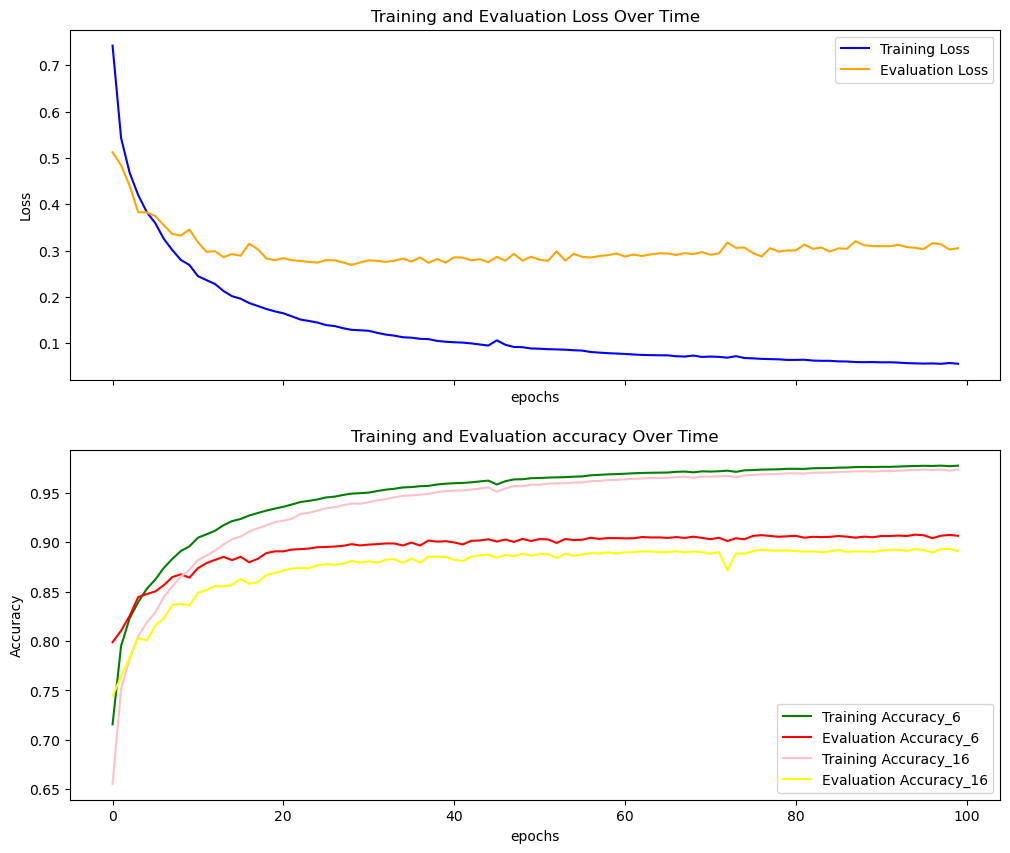

In [16]:
import json
import matplotlib.pyplot as plt

# 从 JSON 文件加载训练和评估日志
with open('D:/TSL/multimask/logs/deeplabv3+/GID_split_dwa_hieraloss2_SGD_jl.json', 'r') as json_file:
    log_data = json.load(json_file)

# 创建一个包含两个子图的图表
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 绘制训练和评估损失
ax1.plot(log_data['train']['epochs'], log_data['train']['loss_6'], label='Training Loss', color='blue')
ax1.plot(log_data['eval']['epochs'], log_data['eval']['loss_6'], label='Evaluation Loss', color='orange')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Evaluation Loss Over Time')
ax1.legend()

# 绘制训练和评估准确率
ax2.plot(log_data['train']['epochs'], log_data['train']['accuracy_6'], label='Training Accuracy_6', color='green')
ax2.plot(log_data['eval']['epochs'], log_data['eval']['accuracy_6'], label='Evaluation Accuracy_6', color='red')
ax2.plot(log_data['train']['epochs'], log_data['train']['accuracy_16'], label='Training Accuracy_16', color='pink')
ax2.plot(log_data['eval']['epochs'], log_data['eval']['accuracy_16'], label='Evaluation Accuracy_16', color='yellow')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Evaluation accuracy Over Time')
ax2.legend()
# 绘制训练和评估准确率

plt.show()


In [19]:
model=model.cuda()
model.load_state_dict(torch.load(r"D:\TSL\multimask\pth\deeplabv3+\GID_split_equal_hieraloss_SGD\epoch-099_loss-0.0965_loss(val)-0.2890_acc-0.9701_miou-0.9191_miou(val)-0.7759.pth"))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


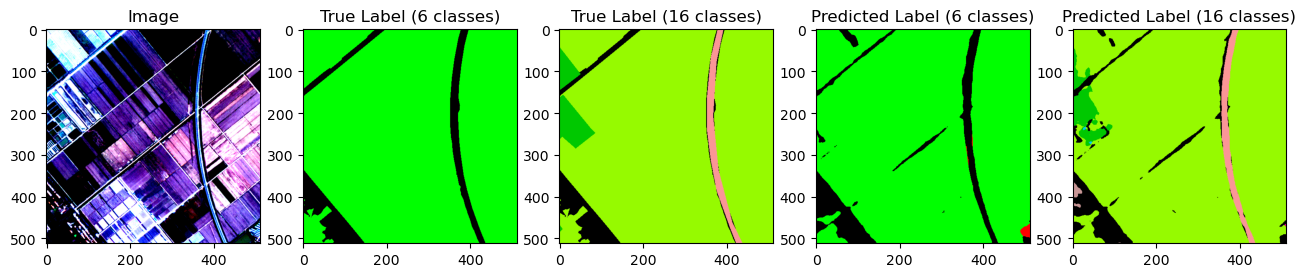

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


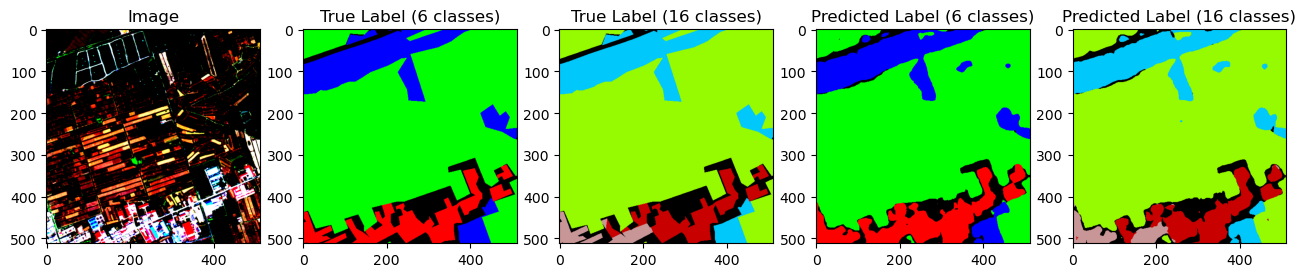

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


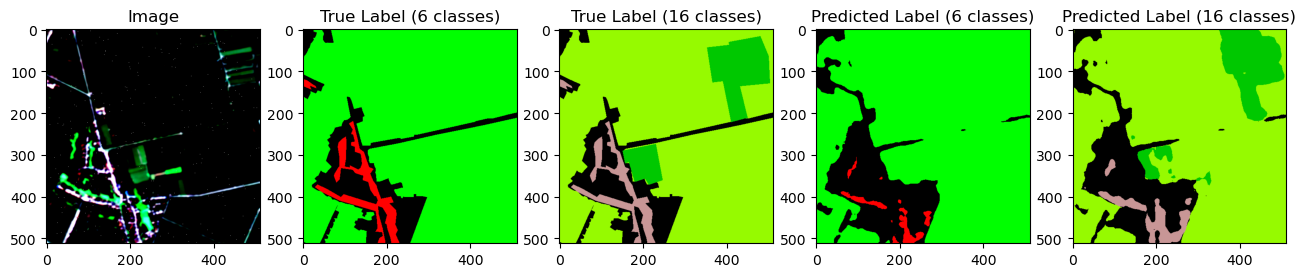

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


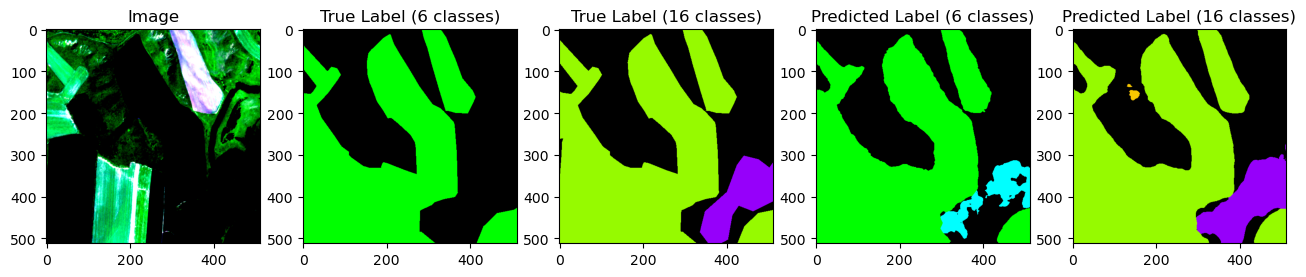

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


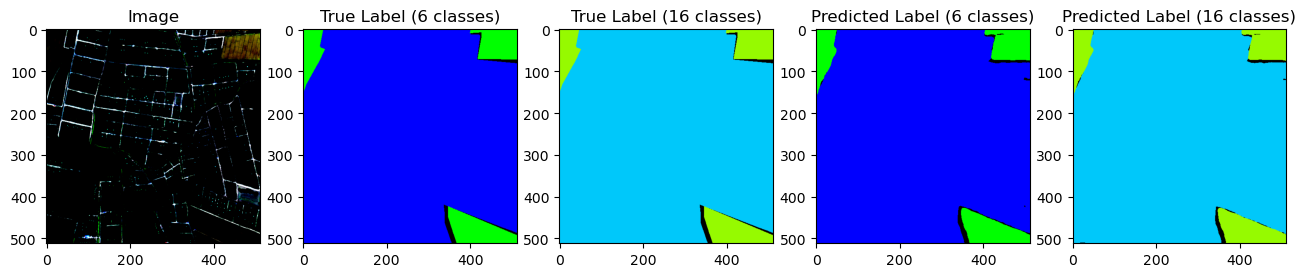

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经定义了 COLORMAP_6c 和 COLORMAP_16c

cm1 = np.array(COLORMAP_6c).astype('uint8')
cm2 = np.array(COLORMAP_16c).astype('uint8')

def visualize_predictions(test_loader, model, device):
    model.eval()  # 将模型设为评估模式
    with torch.no_grad():  # 不计算梯度
        count = 0  # 初始化计数器
        for images, labels1, labels2 in test_loader:
            images, labels1, labels2 = images.to(device), labels1.to(device), labels2.to(device)
            
            # 获取模型的预测结果
            predictions, para = model(images)
            _, predicted_classes1 = torch.max(predictions[0], 1)
            _, predicted_classes2 = torch.max(predictions[1], 1)
            
            # 可视化图像、真实标签和预测结果
            for i in range(len(images)):
                if count == 5:  # 仅显示五张图片
                    return
                image = images[i].permute(1, 2, 0).cpu().numpy()  # 调整图像通道顺序
                true_label_6c = labels1[i].cpu().numpy()
                true_label_16c = labels2[i].cpu().numpy()
                true_label_6c = cm1[true_label_6c]
                true_label_16c = cm2[true_label_16c]
                true_label_6c = Image.fromarray(true_label_6c)
                true_label_16c = Image.fromarray(true_label_16c)
                
                predicted_label_6c = predicted_classes1[i].cpu().numpy()
                predicted_label_16c = predicted_classes2[i].cpu().numpy()
                predicted_label_6c = cm1[predicted_label_6c]
                predicted_label_16c = cm2[predicted_label_16c]
                predicted_label_6c = Image.fromarray(predicted_label_6c)
                predicted_label_16c = Image.fromarray(predicted_label_16c) 
                
                plt.figure(figsize=(16, 8))
                plt.subplot(2, 5, 1)
                plt.imshow(image)
                plt.title('Image')
                
                plt.subplot(2, 5, 2)
                plt.imshow(true_label_6c)
                plt.title('True Label (6 classes)')
                
                plt.subplot(2, 5, 3)
                plt.imshow(true_label_16c)
                plt.title('True Label (16 classes)')
                
                plt.subplot(2, 5, 4)
                plt.imshow(predicted_label_6c)
                plt.title('Predicted Label (6 classes)')
                
                plt.subplot(2, 5, 5)
                plt.imshow(predicted_label_16c)
                plt.title('Predicted Label (16 classes)')
                
                plt.show()
                count += 1

# 在测试集上可视化预测结果
visualize_predictions(test_loader, model, device)


## 加载测试数据

In [10]:
test_root = r"D:\TSL\data\GID10_clip"
def read_test(root=test_root):
    txt_fname = root + '/'+('test.txt')
    # print(txt_fname)
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root,'images',i+'.tif') for i in images]
    # print(data)
    # label = [os.path.join(root,'gtFine',i+'.tif') for i in images]
    label1 = [os.path.join(root,'gtCoarse',i+'.tif') for i in images]
    label2 = [os.path.join(root,'gtFine',i+'.tif') for i in images]
    return data, label1, label2

In [11]:
def image_transforms(data,label1,label2): 
    # 将数据转换成tensor，并且做标准化处理

    im_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # label_tfs = tfs.ToTensor()

    data = im_tfs(data)
    # print(data)
    label1 = image2label_6(label1)
    label1 = torch.from_numpy(label1)
    label2 = image2label_16(label2)
    label2 = torch.from_numpy(label2)
    # label1 = label_tfs(label1)
    # label2 = label_tfs(label2)
    # label = torch.from_numpy(label)# 将numpy数组转换成tensor
    return data,label1,label2

In [12]:
class GIDtest(torch.utils.data.Dataset):
    
    # 构造函数
    def __init__(self, height, width, transforms):

        self.height = height
        self.width = width
        self.fnum = 0    # 用来记录被过滤的图片数
        self.transforms = transforms
        # data_list, label1_list, label2_list = read_images(train=train)
        data_list, label1_list,label2_list= read_test()
        self.data_list = self._filter(data_list)
        # self.label1_list = self._filter(label1_list)
        # self.label2_list = self._filter(label2_list)
        self.label1_list = self._filter(label1_list)
        self.label2_list = self._filter(label2_list)
        
                
        print("测试集：加载了 " + str(len(self.data_list)) + " 张图片和标签" + ",过滤了" + str(self.fnum) + "张图片")
        
    
    # 过滤掉长小于height和宽小于width的图片
    def _filter(self, images): 
        img = []
        for im in images:
            if (Image.open(im).size[1] >= self.height and 
               Image.open(im).size[0] >= self.width):
                img.append(im)
            else:
                self.fnum  = self.fnum+1
        return img
    
    # 重载getitem函数，使类可以迭代
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label1 = self.label1_list[idx]
        label2 = self.label2_list[idx]
        # label =self.label_list[idx]
        
        img = Image.open(img)
        label1 = Image.open(label1).convert('RGB')
        label2 = Image.open(label2).convert('RGB')
        img, label1,label2  = self.transforms(img, label1,label2)
        return img, label1,label2
    
    def __len__(self):
        return len(self.data_list)

In [13]:
'''
image=(C,H,W)
label=(H,W)
'''
height = 512
width = 512
gid_test = GIDtest(height, width, image_transforms)
test_data = DataLoader(gid_test, batch_size=10,shuffle=True)#,num_workers=8

测试集：加载了 1600 张图片和标签,过滤了0张图片


## 测试评价

### 加载最好的模型

In [18]:
model=model.cuda()
model.load_state_dict(torch.load(r"D:\TSL\multimask\pth\deeplabv3+\GID_split_equal_hieraloss_jl\epoch-045_loss-0.0949_loss(val)-0.2775_acc-0.9625_miou-0.9325_miou(val)-0.8140.pth"))

<All keys matched successfully>

In [15]:
np.set_printoptions(suppress=True)
class_num_6=6
class_num_16=16
def fast_hist(a, b, n):
    """
    生成混淆矩阵
    a 是形状为(HxW,)的预测值
    b 是形状为(HxW,)的真实值
    n 是类别数
    """
    # 确保a和b在0~n-1的范围内，k是(HxW,)的True和False数列
    _,a = torch.max(a, dim=1)
    a = a.cpu().numpy()
    b = b.cpu().numpy()
    k = (a >= 0) & (a < n)
    # 横坐标是预测的类别，纵坐标是真实的类别
    hist = np.bincount(a[k].astype(int) + n * b[k].astype(int), minlength=n ** 2).reshape(n, n)
    # hist = np.delete(hist, 0, axis=0)
    # hist = np.delete(hist, 0, axis=1)
    # print(hist[20])
    return hist
 

def per_class_iou(hist):
    """
    hist传入混淆矩阵(n, n)
    """
    # 因为下面有除法，防止分母为0的情况报错
    np.seterr(divide="ignore", invalid="ignore")
    # 交集：np.diag取hist的对角线元素
    # 并集：hist.sum(1)和hist.sum(0)分别按两个维度相加，而对角线元素加了两次，因此减一次
    iou = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    # 把报错设回来
    #np.seterr(divide="warn", invalid="warn")
    # 如果分母为0，结果是nan，会影响后续处理，因此把nan都置为0
    iou[np.isnan(iou)] = 0.
    return iou
 
def per_class_acc(hist):
    """
    :param hist: 混淆矩阵
    :return: 没类的acc和平均的acc
    """
    np.seterr(divide="ignore", invalid="ignore")
    acc_cls = np.diag(hist) / hist.sum(1)
    np.seterr(divide="warn", invalid="warn")
    acc_cls[np.isnan(acc_cls)] = 0.
    return acc_cls
 

# 使用这个函数计算模型的各种性能指标
# 输入网络的输出值和标签值，得到计算结果
def get_MIoU6(pred, label, hist):
    """
    :param pred: 预测向量
    :param label: 真实标签值
    :return: 准确率，每类的准确率，每类的iou, miou
    """
    hist = hist + fast_hist(pred, label, class_num_6)
    # print(hist[20])
    # 准确率
    acc = np.diag(hist).sum() / hist.sum()
    # 每类的准确率
    acc_cls = per_class_acc(hist)
    # 每类的iou
    iou = per_class_iou(hist)
    miou = np.nanmean(iou[:])
    # 频率加权的 IoU (Frequency Weighted IoU, FWIoU)
    freq = hist.sum(1) / hist.sum()
    fwiou = (freq[freq > 0] * iou[freq > 0]).sum()
    
    # 平均每类准确率 (Mean Pixel Accuracy, mPA)
    mpa = np.nanmean(acc_cls)
    return acc, acc_cls, iou, miou, fwiou, mpa, hist

def get_MIoU16(pred, label, hist):
    """
    :param pred: 预测向量
    :param label: 真实标签值
    :return: 准确率，每类的准确率，每类的iou, miou
    """
    hist = hist + fast_hist(pred, label, class_num_16)
    # print(hist[20])
    # 准确率
    acc = np.diag(hist).sum() / hist.sum()
    # 每类的准确率
    acc_cls = per_class_acc(hist)
    # 每类的iou
    iou = per_class_iou(hist)
    miou = np.nanmean(iou[:])
    # 频率加权的 IoU (Frequency Weighted IoU, FWIoU)
    freq = hist.sum(1) / hist.sum()
    fwiou = (freq[freq > 0] * iou[freq > 0]).sum()
    
    # 平均每类准确率 (Mean Pixel Accuracy, mPA)
    mpa = np.nanmean(acc_cls)
    return acc, acc_cls, iou, miou, fwiou, mpa, hist

In [16]:
def test():
    hist1 = np.zeros((6,6))
    hist2 = np.zeros((16,16))
    acc_all1 =0
    acc_all2 =0
    miou_all1=0
    miou_all2=0
    model.eval()
    for step, data in enumerate(test_data):
        img,img_gt1,img_gt2= data
        img = img.to(device)
        img_gt1 = img_gt1.to(device)
        img_gt2 = img_gt2.to(device)
        # 前向传播
        output,parameter= model(img)
        # 计算各项性能指标
        acc1, acc_cls1, iou1, miou1, fwiou1, mpa1, hist1 = get_MIoU6(pred=output[0], label=img_gt1, hist=hist1)

        acc2, acc_cls2, iou2, miou2, fwiou2, mpa2, hist2 = get_MIoU16(pred=output[1], label=img_gt2, hist=hist2)
    print('acc1:',format(acc1, '.4f'))
    print('acc2:',format(acc2, '.4f'))
    print('miou1:',format(miou1,'.4f'))
    print('miou2:',format(miou2,'.4f'))
    print('fwiou1:',format(fwiou1,'.4f'))
    print('fwiou2:',format(fwiou2,'.4f'))
    print('mpa1:',format(mpa1,'.4f'))
    print('mpa2:',format(mpa2,'.4f'))
    print('acc_cls1:',np.array2string(acc_cls1, formatter={'all': lambda x: f'{x:.4f}'}))
    print('acc_cls2:',np.array2string(acc_cls2, formatter={'all': lambda x: f'{x:.4f}'}))
    print('iou1:',np.array2string(iou1, formatter={'all': lambda x: f'{x:.4f}'}))
    print('iou2:',np.array2string(iou2, formatter={'all': lambda x: f'{x:.4f}'}))

In [19]:
#45，equal_hieraloss_级联
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test()

acc1: 0.9009
acc2: 0.8834
miou1: 0.8227
miou2: 0.7592
fwiou1: 0.8212
fwiou2: 0.7937
mpa1: 0.9016
mpa2: 0.8514
acc_cls1: [0.8576 0.9099 0.8564 0.9436 0.8796 0.9625]
acc_cls2: [0.8656 0.7765 0.8919 0.7968 0.8116 0.6689 0.8831 0.5927 0.8908 0.9341
 0.8873 0.8397 0.9426 0.9667 0.9595 0.9143]
iou1: [0.7629 0.8120 0.7870 0.8839 0.7585 0.9320]
iou2: [0.7653 0.6822 0.7720 0.6603 0.6671 0.5839 0.8150 0.5240 0.8096 0.8693
 0.7931 0.7531 0.7316 0.9467 0.9268 0.8477]


### 导出图片

In [20]:
result=[]
with open(r"D:\TSL\data\GID10_clip\test.txt", encoding='utf-8') as f:
    for line in f:
        result.append(line.strip('\n').split('.')[0])
model=model.cuda()
model.eval()
cm1 = np.array(COLORMAP_6c).astype('uint8')
cm2 = np.array(COLORMAP_16c).astype('uint8')

def predict(img, label1,label2): # 预测结果
    img = Variable(img.unsqueeze(0)).cuda()
    out1,out = model(img)
    # print(out.shape)
    pred1 = out1[0].max(1)[1].squeeze().cpu().data.numpy()
    pred2 = out1[1].max(1)[1].squeeze().cpu().data.numpy()
    # print(pred.shape)
    # 将pred的分类值，转换成各个分类对应的RGB值
    pred1 = cm1[pred1]
    pred2 = cm2[pred2]
    # 将numpy转换成PIL对象
    pred1 = Image.fromarray(pred1)
    pred2 = Image.fromarray(pred2)
    return pred1,pred2,label1,label2

for i in range(6000):
    a=int(result[i])
    img_data,img_label1,img_label2 = gid_test[i]
    pred1,pred2,label1,label2 = predict(img_data,img_label1,img_label2)
    save_out1=r"D:\TSL\multimask\result\deeplabv3+\MTL\6_49"
    save_out2=r"D:\TSL\multimask\result\deeplabv3+\MTL\16_49"
    pred1.save(save_out1+ "/" + '%d.png'%a)
    pred2.save(save_out2+ "/" + '%d.png'%a)

IndexError: list index out of range